# Layout optimization

This example demonstrates some basics about running wind farm optimization tasks with `foxes`. All optimizations use the [iwopy](https://github.com/FraunhoferIWES/iwopy) interface in the background (also by Fraunhofer IWES, see link for details). 

In the following we invoke the optimization library [pymoo](https://pymoo.org/) which contains a number of very nice genetic algorithm implementations. Within `foxes` we do that implicitely via the `iwopy` interface.

These are the required imports for this example:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from iwopy.interfaces.pymoo import Optimizer_pymoo

import foxes
import foxes.variables as FV
import foxes.utils.geom2d as gm
from foxes.opt.problems.layout import FarmLayoutOptProblem
from foxes.opt.constraints import FarmBoundaryConstraint, MinDistConstraint
from foxes.opt.objectives import MaxFarmPower

In the following we are tackling the problem of optimizing a wind farm layout for a site near Bremen, Germany. The data of a (coarse) wind rose with 216 states is provided as static data file with name `"wind_rose_bremen.csv"`:
```
state,wd,ws,weight
0,0.0,3.5,0.00158
1,0.0,6.0,0.00244
2,0.0,8.5,0.00319
3,0.0,12.5,0.0036700002
4,0.0,17.5,0.00042
...
```
First, let's create the states object and have a look at the wind rose:

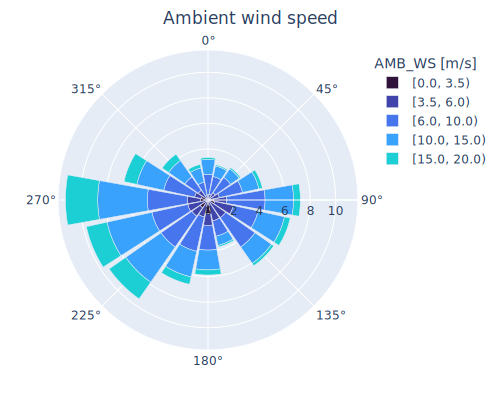

In [2]:
states = foxes.input.states.StatesTable(
    data_source="wind_rose_bremen.csv",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.WEIGHT: "weight"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20])
fig.show("svg")

Next, we need to specify the area within which the turbines are allowed to move during optimization. We use the `foxes.utils.geom2d` sub-package for that purpose (imported as `gm`, see above) which allows us to add and subtract polygons, circles, etc.

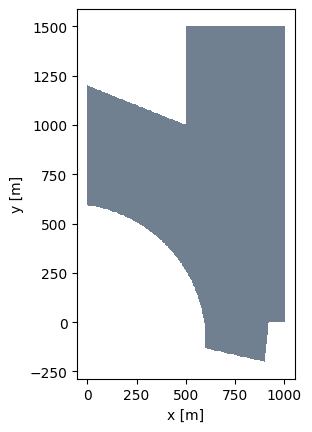

In [3]:
boundary = \
    gm.ClosedPolygon(np.array(
    [[0, 0], [0, 1200], [1000, 800], [900, -200]], dtype=np.float64)) \
    + gm.ClosedPolygon(np.array(
    [[500, 0], [500, 1500], [1000, 1500], [1000, 0]], dtype=np.float64)) \
    - gm.Circle([-100., -100.], 700)

fig, ax = plt.subplots()
boundary.add_to_figure(ax)
plt.show()

Later on we wish to apply boundary constraints that make sure all turbines are placed within this area geometry. These conditions make use of the minimal distance calculation from each point in question to the boundary. We can check the results by plotting again, now using the `fill_mode` option:

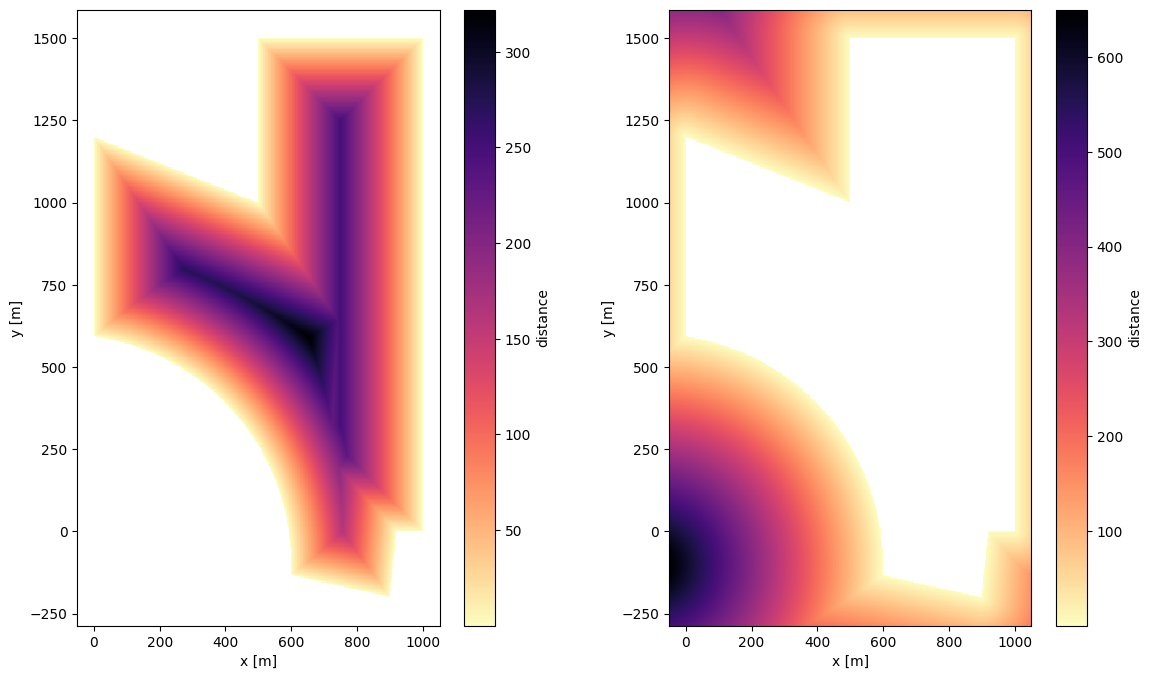

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
boundary.add_to_figure(axs[0], fill_mode="dist_inside")
boundary.add_to_figure(axs[1], fill_mode="dist_outside")
plt.show()

We now setup the model book and a wind farm with 10 turbines in some initial layout, including the boundary:

Turbine 0, T0: layout_opt, NREL5MW
Turbine 1, T1: layout_opt, NREL5MW
Turbine 2, T2: layout_opt, NREL5MW
Turbine 3, T3: layout_opt, NREL5MW
Turbine 4, T4: layout_opt, NREL5MW
Turbine 5, T5: layout_opt, NREL5MW
Turbine 6, T6: layout_opt, NREL5MW
Turbine 7, T7: layout_opt, NREL5MW
Turbine 8, T8: layout_opt, NREL5MW
Turbine 9, T9: layout_opt, NREL5MW


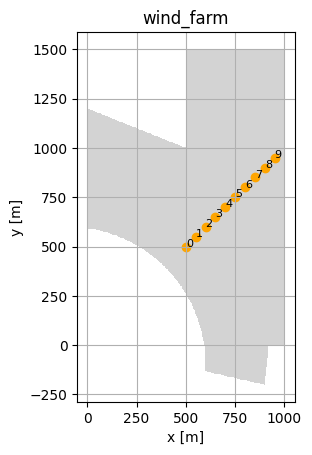

In [5]:
mbook = foxes.models.ModelBook()

farm = foxes.WindFarm(boundary=boundary)
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=np.array([500.0, 500.0]),
    xy_step=np.array([50.0, 50.0]),
    n_turbines=10,
    turbine_models=["layout_opt", "NREL5MW"],
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure()
plt.show()

Notice the appearing turbine model `layout_opt`. This is not part of the model book but will be defined shortly by the optimization problem. In the context of the turbine models it defines where in the model order the optimization variables application should be applied. In our case we are optimizing the (X, Y)-coordinates of the turbines, and they should be updated at the very beginning.

Let's new define the algorithm and the layout optimization problem. The latter should include boundary constraints and a minimal distance of 2 rotor diameters between turbines. Our objective is the maximization of the total wind farm power:

In [6]:
algo = foxes.algorithms.Downwind(
    mbook,
    farm,
    states=states,
    rotor_model="centre",
    wake_models=["Bastankhah025_linear_k002"],
    wake_frame="rotor_wd",
    partial_wakes_model="auto",
    verbosity=0,
)

problem = FarmLayoutOptProblem("layout_opt", algo)
problem.add_objective(MaxFarmPower(problem))
problem.add_constraint(FarmBoundaryConstraint(problem))
problem.add_constraint(
    MinDistConstraint(problem, min_dist=2., min_dist_unit="D")
)
problem.initialize()

Problem 'layout_opt' (FarmLayoutOptProblem): Initializing
---------------------------------------------------------
  n_vars_int   : 0
  n_vars_float : 20
---------------------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
---------------------------------------------------------
  n_constraints: 2
  n_con_cmptns : 55
---------------------------------------------------------


Notice that the two added constraint models imply a total of 55 individual constraint component functions. The wake model choice `Bastankhah025` corresponds to the `Bastankhah2014` deficit model with parameter `sbeta_factor=0.25`. This choice switches off the near wake modelling, rendering the model a bit smoother. This is for demonstrational purposes only and not required for running this example.

Next, we setup the optimizer. In our case we use the genetic algorithm [GA from pymoo](https://pymoo.org/algorithms/soo/ga.html) via the [iwopy](https://github.com/FraunhoferIWES/iwopy) interface, here in vectorized form (flag `vectorize=True`), with 100 generations (`n_max_gen=100`) with population size 50 (`pop_size=50`):

In [7]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(vectorize=True),
    algo_pars=dict(
        type="GA", 
        pop_size=50, 
        seed=42,
    ),
    setup_pars=dict(),
    term_pars=dict(
        type="default",
        n_max_gen=100,
        ftol=1e-6,
        xtol=1e-3,
    ),
)
solver.initialize()
solver.print_info()

Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)
Selecting termination: default (DefaultSingleObjectiveTermination)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 50
  seed: 42

Termination:
------------
  n_max_gen: 100
  ftol: 1e-06
  xtol: 0.001



After all the setup we can now solve the problem:

In [8]:
results = solver.solve()
solver.finalize(results)

print()
print(results)
print(results.problem_results)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       50 |  4.257950E+02 |  1.094916E+03 |             - |             -


     2 |      100 |  2.589298E+02 |  7.141458E+02 |             - |             -


     3 |      150 |  2.108843E+02 |  5.097684E+02 |             - |             -


     4 |      200 |  2.011586E+02 |  3.869307E+02 |             - |             -


     5 |      250 |  1.250281E+02 |  3.238949E+02 |             - |             -


     6 |      300 |  1.250281E+02 |  2.668302E+02 |             - |             -


     7 |      350 |  1.250281E+02 |  2.500554E+02 |             - |             -


     8 |      400 |  1.011095E+02 |  2.198486E+02 |             - |             -


     9 |      450 |  8.571793E+01 |  1.998508E+02 |             - |             -


    10 |      500 |  8.571793E+01 |  1.775495E+02 |             - |             -


    11 |      550 |  2.695093E+01 |  1.482376E+02 |             - |             -


    12 |      600 |  2.695093E+01 |  1.369663E+02 |             - |             -


    13 |      650 |  2.695093E+01 |  1.255097E+02 |             - |             -


    14 |      700 |  2.461710E+01 |  1.135664E+02 |             - |             -


    15 |      750 |  2.461710E+01 |  1.098324E+02 |             - |             -


    16 |      800 |  2.461710E+01 |  9.266611E+01 |             - |             -


    17 |      850 |  2.446678E+01 |  8.484456E+01 |             - |             -


    18 |      900 |  2.440080E+01 |  7.151751E+01 |             - |             -


    19 |      950 |  2.440080E+01 |  5.917821E+01 |             - |             -


    20 |     1000 |  1.998273E+01 |  4.871628E+01 |             - |             -


    21 |     1050 |  1.019366E+01 |  4.071983E+01 |             - |             -


    22 |     1100 |  6.4405916400 |  3.193676E+01 |             - |             -


    23 |     1150 |  4.9794099827 |  2.349004E+01 |             - |             -


    24 |     1200 |  0.000000E+00 |  1.738912E+01 | -5.637094E-01 | -5.637094E-01


    25 |     1250 |  0.000000E+00 |  1.137290E+01 | -5.634633E-01 | -5.637724E-01


    26 |     1300 |  0.000000E+00 |  5.1859595870 | -5.627938E-01 | -5.637724E-01


    27 |     1350 |  0.000000E+00 |  1.6172307553 | -5.627745E-01 | -5.639860E-01


    28 |     1400 |  0.000000E+00 |  0.0289892170 | -5.628375E-01 | -5.641896E-01


    29 |     1450 |  0.000000E+00 |  0.000000E+00 | -5.637568E-01 | -5.669572E-01


    30 |     1500 |  0.000000E+00 |  0.000000E+00 | -5.643675E-01 | -5.669894E-01


    31 |     1550 |  0.000000E+00 |  0.000000E+00 | -5.650502E-01 | -5.674112E-01


    32 |     1600 |  0.000000E+00 |  0.000000E+00 | -5.659980E-01 | -5.674112E-01


    33 |     1650 |  0.000000E+00 |  0.000000E+00 | -5.667832E-01 | -5.675601E-01


    34 |     1700 |  0.000000E+00 |  0.000000E+00 | -5.672502E-01 | -5.681063E-01


    35 |     1750 |  0.000000E+00 |  0.000000E+00 | -5.675992E-01 | -5.686394E-01


    36 |     1800 |  0.000000E+00 |  0.000000E+00 | -5.679654E-01 | -5.687964E-01


    37 |     1850 |  0.000000E+00 |  0.000000E+00 | -5.683403E-01 | -5.693818E-01


    38 |     1900 |  0.000000E+00 |  0.000000E+00 | -5.686760E-01 | -5.697895E-01


    39 |     1950 |  0.000000E+00 |  0.000000E+00 | -5.690004E-01 | -5.700975E-01


    40 |     2000 |  0.000000E+00 |  0.000000E+00 | -5.692837E-01 | -5.702307E-01


    41 |     2050 |  0.000000E+00 |  0.000000E+00 | -5.695943E-01 | -5.704911E-01


    42 |     2100 |  0.000000E+00 |  0.000000E+00 | -5.699206E-01 | -5.704911E-01


    43 |     2150 |  0.000000E+00 |  0.000000E+00 | -5.701337E-01 | -5.709204E-01


    44 |     2200 |  0.000000E+00 |  0.000000E+00 | -5.702841E-01 | -5.709386E-01


    45 |     2250 |  0.000000E+00 |  0.000000E+00 | -5.704866E-01 | -5.711183E-01


    46 |     2300 |  0.000000E+00 |  0.000000E+00 | -5.706579E-01 | -5.711183E-01


    47 |     2350 |  0.000000E+00 |  0.000000E+00 | -5.708801E-01 | -5.713996E-01


    48 |     2400 |  0.000000E+00 |  0.000000E+00 | -5.710350E-01 | -5.715391E-01


    49 |     2450 |  0.000000E+00 |  0.000000E+00 | -5.711441E-01 | -5.715391E-01


    50 |     2500 |  0.000000E+00 |  0.000000E+00 | -5.712496E-01 | -5.716416E-01


    51 |     2550 |  0.000000E+00 |  0.000000E+00 | -5.713817E-01 | -5.718522E-01


    52 |     2600 |  0.000000E+00 |  0.000000E+00 | -5.715419E-01 | -5.720369E-01


    53 |     2650 |  0.000000E+00 |  0.000000E+00 | -5.716514E-01 | -5.720369E-01


    54 |     2700 |  0.000000E+00 |  0.000000E+00 | -5.717930E-01 | -5.724067E-01


    55 |     2750 |  0.000000E+00 |  0.000000E+00 | -5.719196E-01 | -5.724559E-01


    56 |     2800 |  0.000000E+00 |  0.000000E+00 | -5.720247E-01 | -5.724618E-01


    57 |     2850 |  0.000000E+00 |  0.000000E+00 | -5.721929E-01 | -5.726146E-01


    58 |     2900 |  0.000000E+00 |  0.000000E+00 | -5.723602E-01 | -5.731801E-01


    59 |     2950 |  0.000000E+00 |  0.000000E+00 | -5.725403E-01 | -5.731801E-01


    60 |     3000 |  0.000000E+00 |  0.000000E+00 | -5.727676E-01 | -5.733375E-01


    61 |     3050 |  0.000000E+00 |  0.000000E+00 | -5.729560E-01 | -5.734243E-01


    62 |     3100 |  0.000000E+00 |  0.000000E+00 | -5.731750E-01 | -5.737072E-01


    63 |     3150 |  0.000000E+00 |  0.000000E+00 | -5.733388E-01 | -5.740132E-01


    64 |     3200 |  0.000000E+00 |  0.000000E+00 | -5.734659E-01 | -5.741100E-01


    65 |     3250 |  0.000000E+00 |  0.000000E+00 | -5.736455E-01 | -5.742330E-01


    66 |     3300 |  0.000000E+00 |  0.000000E+00 | -5.737939E-01 | -5.742330E-01


    67 |     3350 |  0.000000E+00 |  0.000000E+00 | -5.739554E-01 | -5.743822E-01


    68 |     3400 |  0.000000E+00 |  0.000000E+00 | -5.741208E-01 | -5.744667E-01


    69 |     3450 |  0.000000E+00 |  0.000000E+00 | -5.742680E-01 | -5.749338E-01


    70 |     3500 |  0.000000E+00 |  0.000000E+00 | -5.743868E-01 | -5.749338E-01


    71 |     3550 |  0.000000E+00 |  0.000000E+00 | -5.745348E-01 | -5.752618E-01


    72 |     3600 |  0.000000E+00 |  0.000000E+00 | -5.747172E-01 | -5.753096E-01


    73 |     3650 |  0.000000E+00 |  0.000000E+00 | -5.749630E-01 | -5.754132E-01


    74 |     3700 |  0.000000E+00 |  0.000000E+00 | -5.751114E-01 | -5.754900E-01


    75 |     3750 |  0.000000E+00 |  0.000000E+00 | -5.752606E-01 | -5.755432E-01


    76 |     3800 |  0.000000E+00 |  0.000000E+00 | -5.753353E-01 | -5.755432E-01


    77 |     3850 |  0.000000E+00 |  0.000000E+00 | -5.754139E-01 | -5.756546E-01


    78 |     3900 |  0.000000E+00 |  0.000000E+00 | -5.754952E-01 | -5.758684E-01


    79 |     3950 |  0.000000E+00 |  0.000000E+00 | -5.755655E-01 | -5.758684E-01


    80 |     4000 |  0.000000E+00 |  0.000000E+00 | -5.756239E-01 | -5.758684E-01


    81 |     4050 |  0.000000E+00 |  0.000000E+00 | -5.756727E-01 | -5.758684E-01


    82 |     4100 |  0.000000E+00 |  0.000000E+00 | -5.757191E-01 | -5.759187E-01


    83 |     4150 |  0.000000E+00 |  0.000000E+00 | -5.757659E-01 | -5.759239E-01


    84 |     4200 |  0.000000E+00 |  0.000000E+00 | -5.758197E-01 | -5.759249E-01


    85 |     4250 |  0.000000E+00 |  0.000000E+00 | -5.758685E-01 | -5.760489E-01


    86 |     4300 |  0.000000E+00 |  0.000000E+00 | -5.758966E-01 | -5.760541E-01


    87 |     4350 |  0.000000E+00 |  0.000000E+00 | -5.759310E-01 | -5.760952E-01


    88 |     4400 |  0.000000E+00 |  0.000000E+00 | -5.759618E-01 | -5.760952E-01


    89 |     4450 |  0.000000E+00 |  0.000000E+00 | -5.760000E-01 | -5.760952E-01


    90 |     4500 |  0.000000E+00 |  0.000000E+00 | -5.760619E-01 | -5.760952E-01


    91 |     4550 |  0.000000E+00 |  0.000000E+00 | -5.760752E-01 | -5.760952E-01


    92 |     4600 |  0.000000E+00 |  0.000000E+00 | -5.760853E-01 | -5.761031E-01


    93 |     4650 |  0.000000E+00 |  0.000000E+00 | -5.760913E-01 | -5.761139E-01


    94 |     4700 |  0.000000E+00 |  0.000000E+00 | -5.760990E-01 | -5.761421E-01


    95 |     4750 |  0.000000E+00 |  0.000000E+00 | -5.761088E-01 | -5.761421E-01


    96 |     4800 |  0.000000E+00 |  0.000000E+00 | -5.761172E-01 | -5.761422E-01


    97 |     4850 |  0.000000E+00 |  0.000000E+00 | -5.761255E-01 | -5.761639E-01


    98 |     4900 |  0.000000E+00 |  0.000000E+00 | -5.761346E-01 | -5.761639E-01


    99 |     4950 |  0.000000E+00 |  0.000000E+00 | -5.761445E-01 | -5.761700E-01


   100 |     5000 |  0.000000E+00 |  0.000000E+00 | -5.761554E-01 | -5.761916E-01




Optimizer_pymoo: Optimization run finished
  Success: True
  Best maximize_power = 28809.580622970752

Results problem 'layout_opt':
------------------------------
  Float variables:
    0: X_0000 = 6.073860e+02
    1: Y_0000 = -1.279369e+02
    2: X_0001 = 5.770828e-01
    3: Y_0001 = 7.413702e+02
    4: X_0002 = 9.983482e+02
    5: Y_0002 = 1.028799e+03
    6: X_0003 = 9.984227e+02
    7: Y_0003 = 1.498474e+03
    8: X_0004 = 9.978471e+02
    9: Y_0004 = 4.766128e+02
    10: X_0005 = 2.945769e+00
    11: Y_0005 = 1.188781e+03
    12: X_0006 = 3.937604e+02
    13: Y_0006 = 3.975710e+02
    14: X_0007 = 5.264461e+02
    15: Y_0007 = 9.972161e+02
    16: X_0008 = 9.992966e+02
    17: Y_0008 = 9.079237e-01
    18: X_0009 = 5.037107e+02
    19: Y_0009 = 1.499399e+03
------------------------------
  Objectives:
    0: maximize_power = 2.880958e+04
------------------------------
  Constraints:
    0: boundary_0000 = -6.870192e+00
    1: boundary_0001 = -5.770828e-01
    2: boundary_0002 =

This visualizes the results, once the layout and once the mean wind speed over all wind rose states:

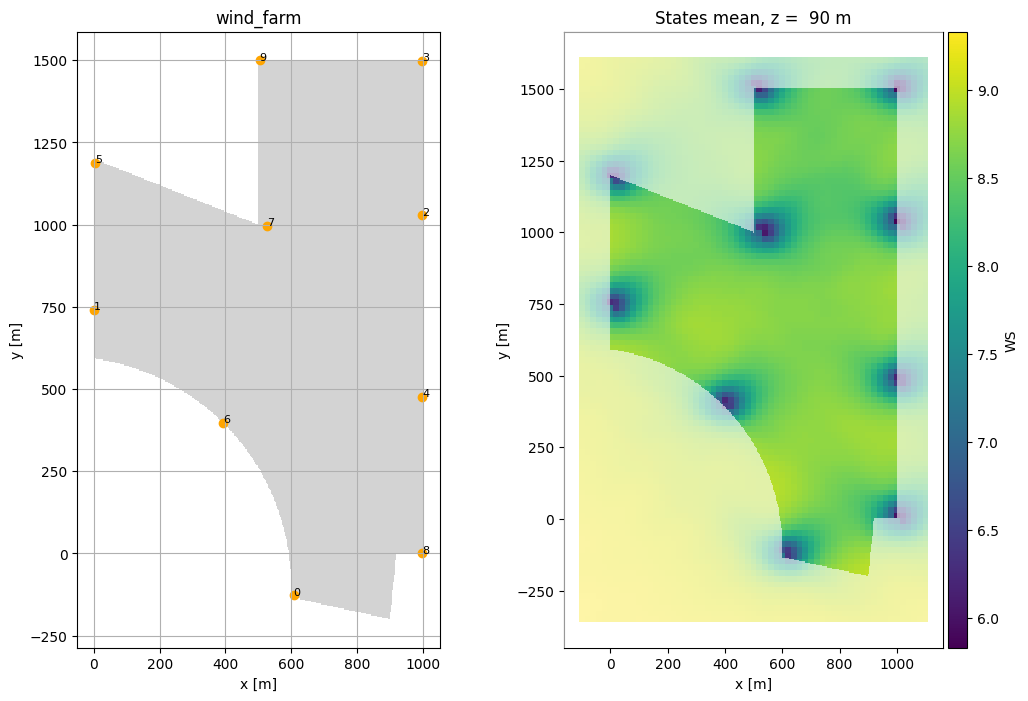

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

foxes.output.FarmLayoutOutput(farm).get_figure(fig=fig, ax=axs[0])

o = foxes.output.FlowPlots2D(algo, results.problem_results)
p_min = np.array([-100.0, -350.0])
p_max = np.array([1100.0, 1600.0])
fig = o.get_mean_fig_xy("WS", resolution=20, fig=fig, ax=axs[1],
    xmin=p_min[0], xmax=p_max[0], ymin=p_min[1], ymax=p_max[1])
dpars = dict(alpha=0.6, zorder=10, p_min=p_min, p_max=p_max)
farm.boundary.add_to_figure(
    axs[1], fill_mode="outside_white", pars_distance=dpars
)

plt.show()

Note that the optimization can also be run using a `DaskRunner`, i.e., optionally in parallel on a (local) cluster. For that invoke the `runner` parameter when creating the problem within a`with` block and solve the problem as before:

```python
with foxes.utils.runners.DaskRunner(scheduler="distributed") as runner:

    problem = FarmLayoutOptProblem("layout_opt", algo, runner=runner)
    ...
    solver = ...
    ...
    results = solver.solve()
    
```

Anything within the `with` block will then be calculated using the `runner`. This includes the output figures, if they appear there as well.